# **Custom Scoring**

This notebook creates a customer support agent which will generate responses to some frequent customer support prompts and score them based on a set of criteria we define. It aims to show ease of use of Judgment Lab's CustomScorer function as well as how to monitor and view these final results.

This notebook makes use of various classes within the `judgeval` library, including `Example`, `ExampleScorer`, `Tracer`, and `wrap`.

To run this notebook, select **Runtime* -> Run All*

In [ ]:
# First, let's install some dependencies
!pip install judgeval openai python-dotenv -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 44.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.7/95.7 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 80.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 4.7 MB/s eta 0:00:00


# Setup

Judgment Labs helps users monitor and evaluate agents in production. We use some of the infrastructure created by Judgment Labs in this notebook to demonstrate this functionality on the Wikiracer agent we will create.

You can get your Judgment API key and Org ID for free on the [Judgment Labs Platform](https://app.judgmentlabs.ai/register)
```
JUDGMENT API_KEY, JUDGMENT_ORG_ID
```



This notebook also makes some calls via the OPENAI API. In order to run the following cells, create and add in your own `OPENAI_API_KEY` in the following cell.

In [ ]:
# set api keys
import os
from dotenv import load_dotenv

os.environ['OPENAI_API_KEY'] =
os.environ["JUDGMENT_API_KEY"] =
os.environ["JUDGMENT_ORG_ID"] =


load_dotenv()

False

In [ ]:
# Now we will add in some necessary imports.
import os
import json
import asyncio
from typing import Dict
from dotenv import load_dotenv

from openai import AsyncOpenAI
from judgeval import JudgmentClient
from judgeval.data import Example
from judgeval.scorers.example_scorer import ExampleScorer
from judgeval.tracer import Tracer, wrap


# Wrap
Here, we call the `judgeval` `wrap` function.

The `wrap()` function is a key judgeval feature that adds tracing capabilities
to your model. This allows judgeval to automatically track:
- All model calls
- Input prompts and responses
- Latency and token usage
- Error states


In [ ]:
openai_client = wrap(AsyncOpenAI(api_key=os.getenv("OPENAI_API_KEY")))


# Tracer
The `Tracer` creates a project in judgeval where all traces will be logged.
Every function decorated with `@judgment.observe()` will appear in this project,
allowing you to see the full execution tree of your agent.

**Arguments:**
- `project_name`: Name of your judgeval project
- `api_key`: Your judgeval API key (get this from the dashboard)

In [ ]:
judgment = Tracer(
    project_name="ticket-agent",  # Name your project
    api_key=os.getenv("JUDGMENT_API_KEY")  # Get this from judgeval dashboard. Also instantiated above.
)


# Dataset

Now we create a test dataset. If we were training a model, we would need both train and test sets, but this notebook only focuses on evaluation so we only need a test set. In the following cell, we created 20 realistic customer support tickets, but feel free to change both the content and quantity of this test set.

In [ ]:
# Cell 5: Create test dataset (20 realistic customer support tickets)
TEST_TICKETS = [
    "My package was supposed to arrive yesterday but it's still not here. Order #45231",
    "I was charged twice for my subscription this month. Can you help?",
    "How do I reset my password? I've tried the reset link but it's not working",
    "The product I received is damaged. What are my options for a replacement?",
    "I want to cancel my subscription but I can't find the option in my account",
    "Your website is showing an error when I try to checkout. This is urgent!",
    "I never received a confirmation email for my order placed 3 days ago",
    "The tracking number you provided doesn't work on the carrier's website",
    "I'd like to upgrade my plan. What's the process and pricing?",
    "My account was locked after too many failed login attempts. Please help!",
    "Can I change the shipping address for order #78234? It hasn't shipped yet",
    "I'm missing an item from my order. Only received 2 out of 3 items",
    "The discount code SAVE20 isn't working at checkout. Is it still valid?",
    "I need a receipt for my recent purchase for expense reimbursement",
    "How long does shipping typically take to Canada?",
    "I was promised a refund 2 weeks ago but still haven't received it",
    "Is there a phone number I can call? I prefer to speak with someone directly",
    "My credit card was declined but I know there are sufficient funds",
    "Can you help me understand the differences between your Standard and Premium plans?",
    "I accidentally ordered the wrong size. Can I exchange it?"
]

print(f"Created {len(TEST_TICKETS)} test tickets")

Created 20 test tickets


# Varying Prompts
In order to see the results of our scorer, we need to write a few different types of prompts. Here we define three different kinds: forma, empathetic, and bad. The ideal results of this notebook would show that both formal and empathetic prompts are positive responses to customer support tickets while the bad prompts should be scored badly.

In [ ]:
# we will define three types of prompts. One is formal, one is empathetic, and one is bad.
FORMAL_PROMPT = """You are a professional customer service representative.
Respond formally and concisely to customer inquiries. Focus on efficiency and clarity."""

# Strategy 2: Empathetic and warm
EMPATHETIC_PROMPT = """You are a friendly and empathetic customer service agent.
Show understanding for the customer's situation and respond warmly.
Balance empathy with providing clear, actionable solutions."""

# Strategy 3: Intentionally poor (for validation)
BAD_PROMPT = """You are a customer service agent.
Keep responses very brief. Don't provide detailed solutions."""

print("✓ Three prompt strategies defined:")
print("  1. Formal - Professional and concise")
print("  2. Empathetic - Warm and understanding")
print("  3. Bad - Intentionally unhelpful (for validation)")

✓ Three prompt strategies defined:
  1. Formal - Professional and concise
  2. Empathetic - Warm and understanding
  3. Bad - Intentionally unhelpful (for validation)


# Decorator
In the following cell, notice the `judgment.observe()` decorator. This works with the `wrap` call we made earlier to allow judgment to log the inputs and outputs associated with this function.

In [ ]:
# Cell 7: Build customer support agent (CORRECTED)
@judgment.observe(span_type="function")
async def customer_support_agent(ticket: str, system_prompt: str) -> Dict:
    """
    Generate a customer support response using OpenAI.

    Args:
        ticket: Customer's support request
        system_prompt: Instructions for the agent's behavior

    Returns:
        Dict containing the ticket, response, and metadata
    """
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": ticket}
    ]

    # Generate response (auto-tracked by wrapped client)
    response_obj = await openai_client.chat.completions.create(
        model="gpt-4o-mini",
        messages=messages,
        max_tokens=250,
        temperature=0.7
    )

    # Extract just the text content from the response
    agent_response = response_obj.choices[0].message.content.strip()

    # Return structured output for evaluation
    return {
        "ticket": ticket,
        "response": agent_response,
        "system_prompt": system_prompt,
        "model": "gpt-4o-mini"
    }

print("✓ Customer support agent created")

✓ Customer support agent created


# Class Definition
The following cell is simple, but created for clarity of the SupportTicketExample class. In this notebook, we define this to be only a two field class, but feel free to make it more complicated as need be.

In [ ]:
# create SupportTicketExample class
class SupportTicketExample(Example):

  ticket: str
  prompt_type: str

# Custom Scorer
The following cell defines teh SupportQualityScorer which extends the Judgment ExampleScorer class.

Notice the class input of type ```ExampleScorer```. This class extends the ```BaseScorer``` class and requires the user to implement

```async def a_score_example(self, example: Example, *args, **kwargs) -> float:```

This method will asynchronously score each example, and the scorer should set three key fields:



*   ```self.name``` : scorer name shown in the Judgment Labs platform dashboard
*   ```self.score``` : numeric metric value (e.g., Pass@k in ```[0, 1]```)
*   ```self.reason``` : human-readable explanation or context behind the score

# Defining Custom Scorer
The primary goal of this notebook is to create our own scorer based on the goals we want to achieve. Here, we define some criteria that we deem necessary in a response (namely helpfulness, tone, completeness, and accuracy) and then ask the model to output a score.

In [ ]:
# Cell 9: Create CustomScorer
class SupportQualityScorer(ExampleScorer):
    """
    CustomScorer that evaluates customer support response quality.

    Uses GPT-4 as a judge to assess responses across multiple dimensions:
    - Helpfulness: Does it address the customer's issue?
    - Tone: Is it appropriate for customer service?
    - Completeness: Are actionable next steps provided?
    - Accuracy: No false promises or incorrect information?
    """

    name: str = "Support Quality Scorer"
    score_type: str = "CustomerSupport"

    async def a_score_example(self, example: SupportTicketExample, *args, **kwargs) -> float:
        """
        Score a customer support interaction.

        Args:
            example: SupportTicketExample with ticket and response fields

        Returns:
            float: Score between 0.0 and 1.0
        """
        # Access fields directly from the example
        ticket = example.ticket
        response = example.response

        # Use GPT-4 as judge
        judge_response = await self._evaluate_with_llm(ticket, response)

        # Extract score and reasoning
        score = judge_response.get("score", 0.0)
        self.reason = judge_response.get("reasoning", "No reasoning provided")

        return float(score)

    async def _evaluate_with_llm(self, ticket: str, response: str) -> Dict:
        """
        Use GPT-4 to evaluate response quality.

        Returns:
            Dict with 'score' (float) and 'reasoning' (str)
        """
        judge_prompt = f"""Evaluate this customer support interaction on a scale of 0.0 to 1.0.

Customer Ticket:
{ticket}

Agent Response:
{response}

Evaluate based on these criteria:
1. Helpfulness - Does it address the customer's issue directly?
2. Tone - Is it appropriate and professional for customer service?
3. Completeness - Are clear, actionable next steps provided?
4. Accuracy - No false promises or misleading information?

You must respond with ONLY a valid JSON object, nothing else. No explanation before or after.
Format: {{"score": 0.85, "reasoning": "Brief explanation of the score"}}"""

        try:
            response_obj = await openai_client.chat.completions.create(
                model="gpt-4o",  # Use GPT-4 for judging
                messages=[{"role": "user", "content": judge_prompt}],
                max_tokens=200,
                temperature=0.3,  # Lower temperature for consistent judging
                response_format={"type": "json_object"}  # Force JSON output
            )

            content = response_obj.choices[0].message.content.strip()

            # Try to extract JSON if there's extra text
            if not content.startswith("{"):
                # Find first { and last }
                start = content.find("{")
                end = content.rfind("}") + 1
                if start != -1 and end != 0:
                    content = content[start:end]

            result = json.loads(content)

            # Ensure score is in valid range
            result["score"] = max(0.0, min(1.0, float(result.get("score", 0.0))))

            return result

        except Exception as e:
            print(f"Error in scoring: {str(e)}")
            print(f"Raw response: {content if 'content' in locals() else 'No response'}")
            return {
                "score": 0.0,
                "reasoning": f"Evaluation failed: {str(e)}"
            }

print("✓ CustomScorer created with LLM-as-judge evaluation")

✓ CustomScorer created with LLM-as-judge evaluation


# Response Generation

Here, we actually call upon the model to create response generations. Since we wrapped our initial call, we can get access to what the input/output pairs are in the Judgment platform.

In [ ]:
# Cell 10: Generate responses for all tickets with all three prompt strategies
async def generate_all_responses():
    """Generate responses for all tickets using three prompt strategies."""

    formal_examples = []
    empathetic_examples = []
    bad_examples = []

    print("Generating responses for 20 tickets with 3 prompt variants...")
    print("This will take ~1-2 minutes...\n")

    for i, ticket in enumerate(TEST_TICKETS, 1):
        # Generate with formal prompt
        formal_result = await customer_support_agent(ticket, FORMAL_PROMPT)
        formal_examples.append(
            SupportTicketExample(
                ticket=ticket,
                response=formal_result["response"],
                prompt_type="formal"
            )
        )

        # Generate with empathetic prompt
        empathetic_result = await customer_support_agent(ticket, EMPATHETIC_PROMPT)
        empathetic_examples.append(
            SupportTicketExample(
                ticket=ticket,
                response=empathetic_result["response"],
                prompt_type="empathetic"
            )
        )

        # Generate with bad prompt (for validation)
        bad_result = await customer_support_agent(ticket, BAD_PROMPT)
        bad_examples.append(
            SupportTicketExample(
                ticket=ticket,
                response=bad_result["response"],
                prompt_type="bad"
            )
        )

        if i % 5 == 0:
            print(f"✓ Completed {i}/20 tickets")

    total = len(formal_examples) + len(empathetic_examples) + len(bad_examples)
    print(f"\n✓ Generated {total} total responses ({len(formal_examples)} per strategy)")

    return formal_examples, empathetic_examples, bad_examples

# Run the async function
formal_examples, empathetic_examples, bad_examples = await generate_all_responses()

Generating responses for 20 tickets with 3 prompt variants...
This will take ~1-2 minutes...

✓ Completed 5/20 tickets
✓ Completed 10/20 tickets
✓ Completed 15/20 tickets
✓ Completed 20/20 tickets

✓ Generated 60 total responses (20 per strategy)


# CustomScorer Evaluation

Now we tie it all together. Specifically notice the `judgment.async_evaluate `call which will use our scorer and dataset and output all necessary information in the platform.

In [ ]:
# Cell 12: Run evaluation with CustomScorer
from judgeval import JudgmentClient

# Initialize the JudgmentClient
client = JudgmentClient()

print("Running evaluations with CustomScorer...")
print("This will take a few minutes...\n")

# Evaluate formal prompt responses
print("1/3 Evaluating formal prompt responses...")
formal_results = client.run_evaluation(
    examples=formal_examples,
    scorers=[SupportQualityScorer(threshold=0.8)],
    model="gpt-4o",  # Model for the scorer's LLM judge
    project_name="ticket-agent"
)
print("✓ Formal prompt evaluation complete\n")

# Evaluate empathetic prompt responses
print("2/3 Evaluating empathetic prompt responses...")
empathetic_results = client.run_evaluation(
    examples=empathetic_examples,
    scorers=[SupportQualityScorer(threshold=0.8)],
    model="gpt-4o",
    project_name="ticket-agent"
)
print("✓ Empathetic prompt evaluation complete\n")

# Evaluate bad prompt responses (for validation)
print("3/3 Evaluating bad prompt responses...")
bad_results = client.run_evaluation(
    examples=bad_examples,
    scorers=[SupportQualityScorer(threshold=0.8)],
    model="gpt-4o",
    project_name="ticket-agent"
)
print("✓ Bad prompt evaluation complete\n")

print("=" * 80)
print("🎉 All evaluations complete!")
print("=" * 80)
print("\n📊 View detailed results at: https://app.judgmentlabs.ai/")
print("   Project: ticket-agent")

# Print summary
print(f"\nFormal examples evaluated: {len(formal_examples)}")
print(f"Empathetic examples evaluated: {len(empathetic_examples)}")
print(f"Bad examples evaluated: {len(bad_examples)}")

Running evaluations with CustomScorer...
This will take a few minutes...

1/3 Evaluating formal prompt responses...


Evaluating 20 example(s) in parallel: |██████████|100% (20/20) [Time Taken: 00:06,  3.06Example/s]


🔍 You can view your evaluation results here: ]8;id=681015;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/e57f7f0d-849a-43fd-a4e8-7fbdd3e97740/tests/ea8d3d0b-4c9a-40f1-8b3a-4b1cf43e86ef\View Results]8;;\

✓ Formal prompt evaluation complete

2/3 Evaluating empathetic prompt responses...


Evaluating 20 example(s) in parallel: |██████████|100% (20/20) [Time Taken: 00:05,  3.36Example/s]


🔍 You can view your evaluation results here: ]8;id=334987;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/e57f7f0d-849a-43fd-a4e8-7fbdd3e97740/tests/69deaa0e-20cb-41b9-b230-f0d4414b573a\View Results]8;;\

✓ Empathetic prompt evaluation complete

3/3 Evaluating bad prompt responses...


Evaluating 20 example(s) in parallel: |██████████|100% (20/20) [Time Taken: 00:05,  3.42Example/s]


🔍 You can view your evaluation results here: ]8;id=338380;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/e57f7f0d-849a-43fd-a4e8-7fbdd3e97740/tests/b3bf41f9-944c-49e5-b6f6-47167ac8e833\View Results]8;;\

✓ Bad prompt evaluation complete

🎉 All evaluations complete!

📊 View detailed results at: https://app.judgmentlabs.ai/
   Project: ticket-agent

Formal examples evaluated: 20
Empathetic examples evaluated: 20
Bad examples evaluated: 20


# Test Success Rates

In this first image, we can see the red/green distributions. Green means we passed the 0.8 threshold defined in the previous cell and red means we failed. The first bar corresponds to the formal prompt, the middle is empathetic, and the last is bad prompt. We can see both the formal and empathetic are generally sucessful prompts while the bad has been accurately classified negatively.


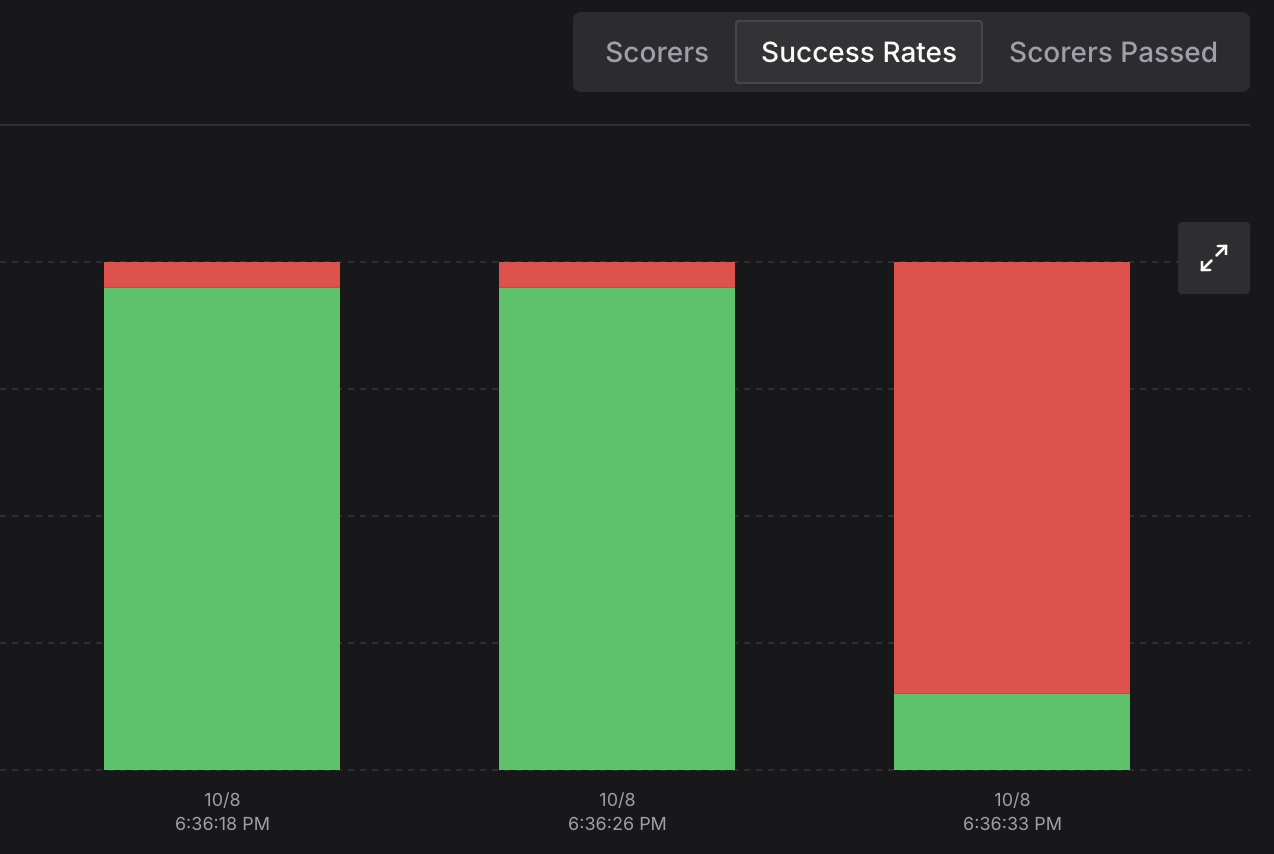

# Bad Prompt Example

Here we outline the input/output (which we have access to because of our decorator). It shows us our score, the logs, and why the score was generated. This can help us evaluate the strength of the example, prompt, scoring mecahnism, and more.

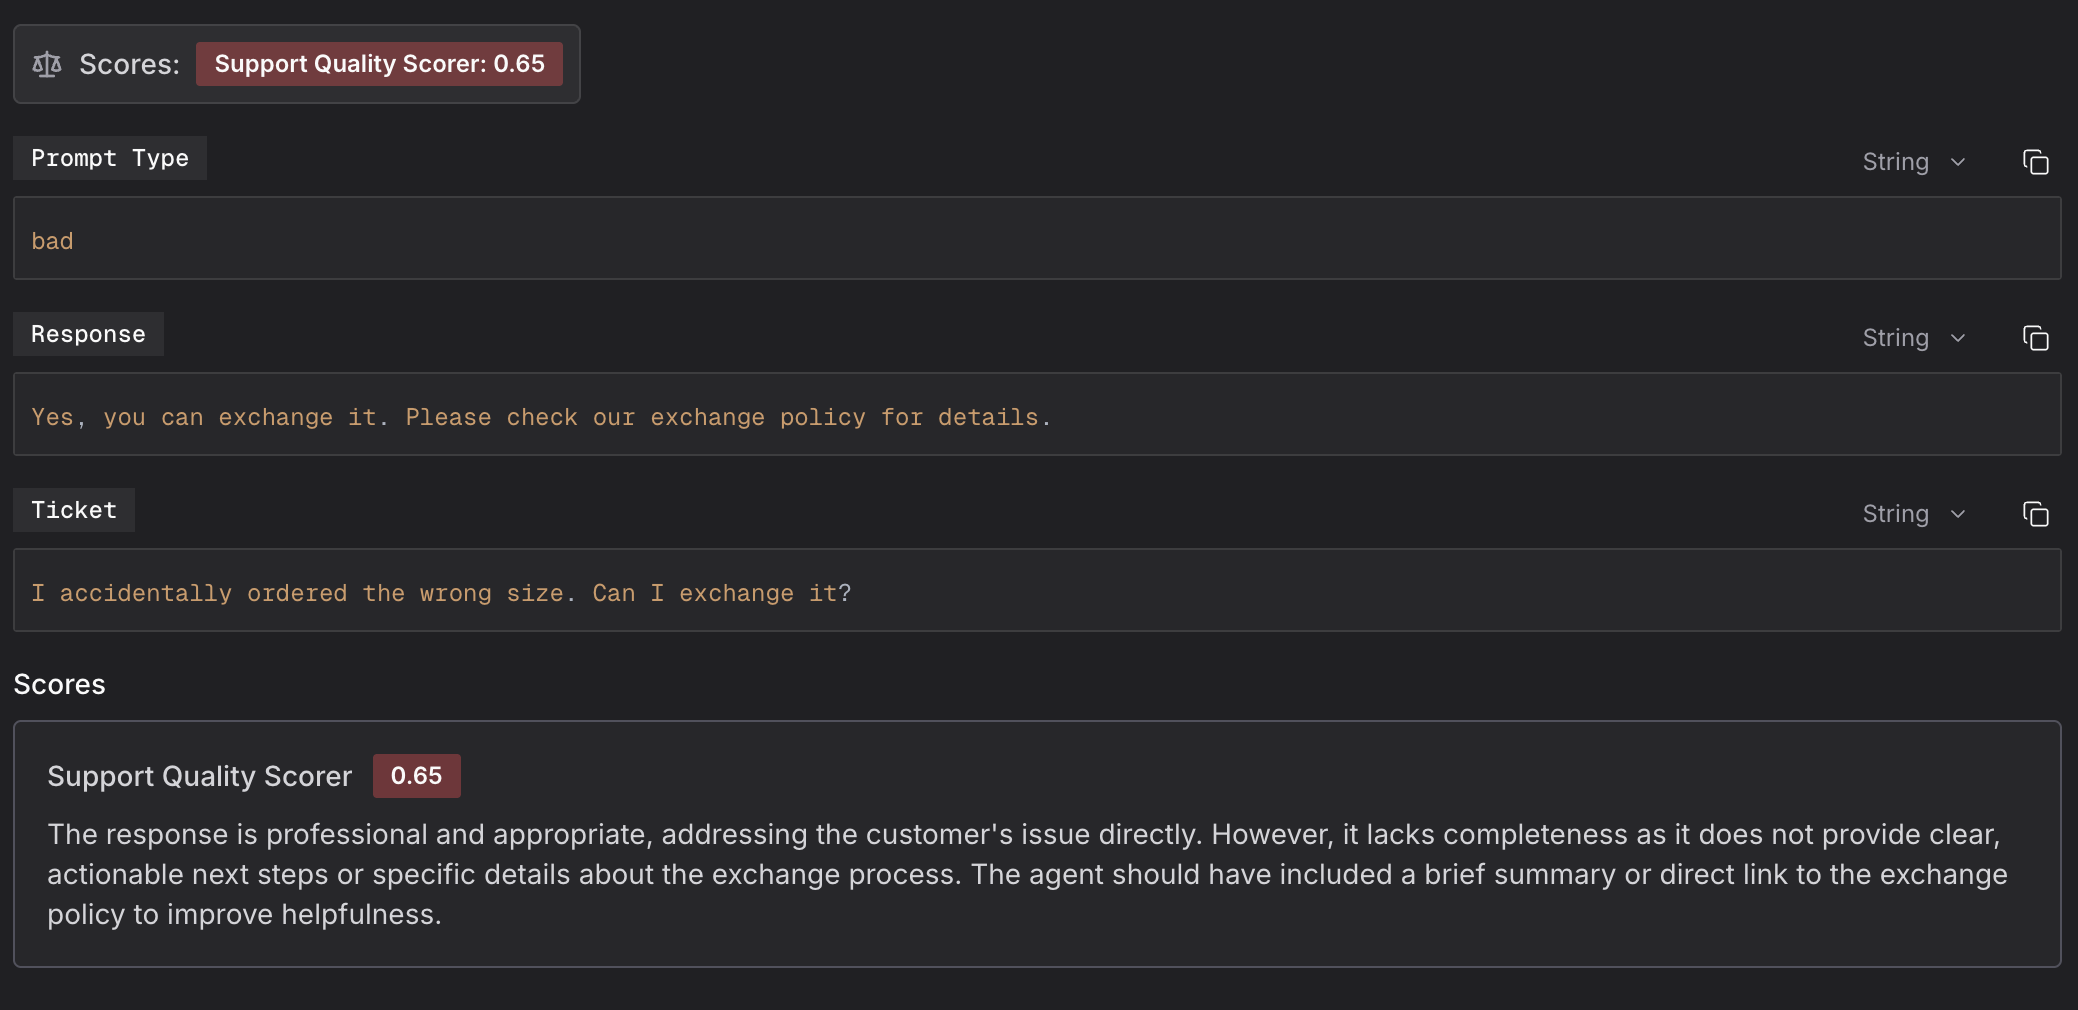